In [2]:
import numpy as np 
import json
from PIL import Image 
import matplotlib.pyplot as plt 
%matplotlib inline

import torch 
import torchvision 
from torchvision import models,transforms

In [3]:
#载入已完成训练的模型
#第一次从网上下载

#生成VGG-16实例
use_predicted = True  #使用已经训练好的参数
net = models.vgg16(pretrained=use_predicted)
net.eval() #设置为推理模式

#输出网络结构
print(net)

C:\Users\32373\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\32373\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\32373/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

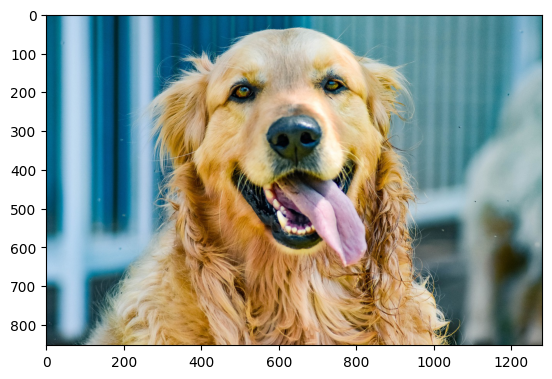

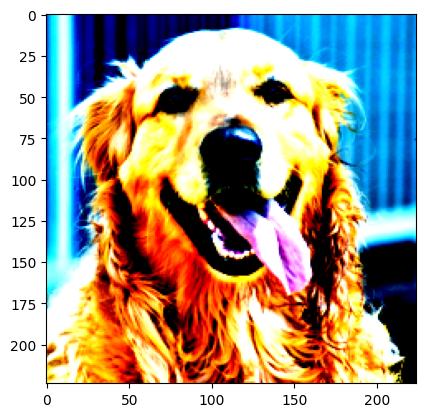

In [6]:
class BaseTransform():
    """
    调整图片的尺寸并对颜色进行标准化
    """
    def __init__(self,resize,mean,std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
    def __call__(self,img):
        return self.base_transform(img)

#1. 读取图片
image_file_path='./data/dog.jpg'
img = Image.open(image_file_path)  #[高][宽][RGB]

#2. 显示处理前的图片
plt.imshow(img)
plt.show()

#3. 同时显示预处理后的图片
resize=224
mean=(0.485,0.456,0.406)
std=(0.229,0.224,0.225)
transform = BaseTransform(resize,mean,std)
img_transform=transform(img)

#将（颜色、高度、宽度）转化为（高度、宽度、颜色），并将取值限制在0~1
img_transform = img_transform.numpy().transpose((1,2,0))
img_transform = np.clip(img_transform,0,1)
plt.imshow(img_transform)
plt.show()


### 根据输出结果预测标签的后处理类的编写

In [7]:
#载入ILSVRC的分类标签信息，并保存在字典中
ILSVRC_class_index=json.load(open('./data/imagenet_class_index.json','r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [9]:
#根据输出结果对标签进行预测后处理类
class ILSVRCPredictor():
    def __init__(self,class_index):
        self.class_index = class_index 
    def predict_max(self,out):
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name

### 进行图片预测

In [21]:
#载入ILSVRC的分类标签信息，并保存在字典中
ILSVRC_class_index=json.load(open('./data/imagenet_class_index.json','r'))

#生成ILSVRCPredictor的实例
predictor = ILSVRCPredictor(ILSVRC_class_index)

#读取输入的图像
#1. 读取图片
image_file_path='./data/dog.jpg'
img = Image.open(image_file_path)  #[高][宽][RGB]
def predict(img):
    transform = BaseTransform(resize,mean,std)
    img_transform=transform(img)
    inputs = img_transform.unsqueeze_(0)
    # img_transform.shape
    out = net(inputs)
    return predictor.predict_max(out)

#输出预测结果
predict(img)


'golden_retriever'